In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import csv

csv_path = 'gdrive/MyDrive/pantun (1).csv'
df = pd.read_csv(csv_path)

In [3]:
df.tail()

,teks,tipe
485,orang palembang menanam padi \n negeri malaka ...,Pantun Nasihat
486,burung kakatua \n hinggap dijendela \n siapa y...,Pantun Nasihat
487,Burung kakak tua udah tak berdaya \n Burung ad...,Pantun Nasihat
488,kucing kurus mandi dipapan \n papan nya sikayu...,Pantun Nasihat
489,disana gunung disini gunung \n ditengah tengah...,Pantun Nasihat


In [4]:
df = df.drop(columns='tipe')
df.head()

,teks
0,Pakai baju ukurannya pas \n Baju biru pemberia...
1,Orang bijak cinta bahasa \n Bahasa luas Bahasa...
2,Kepada siapa datangnya wahyu \n Kepada Nabi wa...
3,Citah perang melawan citah \n Seekor pelatuk m...
4,"Ada gadis perawan, \n paling cantik di kampung..."


In [5]:
def seperate_lines(df):
  df[['Satu','Dua','Tiga','Empat','Lima','enam','tujuh','lapan','lan','luh']] = df.teks.str.split("\\",expand=True,)
  new_df = df.drop(['teks','Lima','enam','tujuh','lapan','lan','luh'], axis=1)
  return new_df

def remove_row_with_null(df):
  null_satu = df.index[df['Satu'].isnull()].tolist()
  null_dua = df.index[df['Dua'].isnull()].tolist()
  null_tiga = df.index[df['Tiga'].isnull()].tolist()
  null_empat = df.index[df['Empat'].isnull()].tolist()

  df.drop(null_satu, inplace=True)
  df.drop(null_dua, inplace=True)
  df.drop(null_tiga, inplace=True)
  df.drop(null_empat, inplace=True)
  return df

def remove_enter(df):
  for index, row in df.iterrows():
    row['Dua'] = row['Dua'][2:]
    row['Tiga'] = row['Tiga'][2:]
    row['Empat'] = row['Empat'][2:]
  return df

In [6]:
# Seperate every line into different columns

new_df = seperate_lines(df)
new_df = remove_row_with_null(new_df)
new_df = remove_enter(new_df)
new_df.drop(columns=['Satu', 'Dua'], inplace=True)
new_df.tail()

,Tiga,Empat
485,putus cinta jangan bersedih,dunia ini masih panjang
486,siapa yang jatuh cinta,pasti cemburu buta
487,Makasi kakek telah berjuang bela negara,Sekarang adek bahagia di hari MERDEKA
488,aku kurus bukan karena kurang makan,tetapi mikirin sijantung hati
489,kesana bingung kesini bingung,itulah namanya jatuh hati


In [7]:
sentence = []
for row in new_df['Tiga']:
  sentence.append(row)
for row in new_df['Empat']:
  sentence.append(row)

corpus = pd.Series(sentence)

corpus = corpus.str.replace(r'[^\w\s]+', '', -1)
corpus = corpus.str.lower()
corpus = corpus.drop_duplicates()
corpus.replace('', np.nan, inplace=True)
corpus.dropna(inplace=True)
corpus = corpus.reset_index(drop=True)

for index, isi in enumerate(corpus):
  corpus[index] = corpus[index][:-1]
  the_string = corpus[index].split(' ')[::-1]
  # print(the_string)
  corpus[index] = ' '.join(the_string)

corpus.describe()

count                           943
unique                          943
top       tidur hendak tuan mana di
freq                              1
dtype: object

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [10]:
tokenizer.word_index

{'yang': 1,
 'di': 2,
 'jangan': 3,
 'cinta': 4,
 'kalau': 5,
 'tak': 6,
 'kita': 7,
 'hati': 8,
 'tidak': 9,
 'orang': 10,
 'jika': 11,
 'dengan': 12,
 'kasih': 13,
 'aku': 14,
 'ke': 15,
 'kau': 16,
 'kamu': 17,
 'dan': 18,
 'dari': 19,
 'banyak': 20,
 'apa': 21,
 'itu': 22,
 'ilmu': 23,
 'dunia': 24,
 'bila': 25,
 'karena': 26,
 'adat': 27,
 'sudah': 28,
 'mati': 29,
 'selalu': 30,
 'untuk': 31,
 'ayah': 32,
 'hanya': 33,
 'ada': 34,
 'bukan': 35,
 'hari': 36,
 'menjadi': 37,
 'malam': 38,
 'tapi': 39,
 'ingin': 40,
 'jadi': 41,
 'dapat': 42,
 'agar': 43,
 'sayang': 44,
 'guru': 45,
 'anak': 46,
 'memang': 47,
 'pernah': 48,
 'tuan': 49,
 'hidup': 50,
 'belajar': 51,
 'takkan': 52,
 'tuhan': 53,
 'suka': 54,
 'akan': 55,
 'cantik': 56,
 'dalam': 57,
 'lagi': 58,
 'sampai': 59,
 'baik': 60,
 'budi': 61,
 'bisa': 62,
 'siapa': 63,
 'apakah': 64,
 'pasti': 65,
 'mana': 66,
 'badan': 67,
 'ku': 68,
 'pandai': 69,
 'kami': 70,
 'hilang': 71,
 'juga': 72,
 'ga': 73,
 'bahagia': 74,
 'sena

In [11]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            165300    
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 300)            301200    
_________________________________________________________________
dropout (Dropout)            (None, 7, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 826)               83426     
_________________________________________________________________
dense_1 (Dense)              (None, 1653)              1367031   
Total params: 2,077,357
Trainable params: 2,077,357
Non-trainable params: 0
______________________________________________

In [13]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
96/96 [==============================] - 10s 54ms/step - loss: 8.1150 - accuracy: 0.0155
Epoch 2/100
96/96 [==============================] - 5s 52ms/step - loss: 6.6123 - accuracy: 0.0233
Epoch 3/100
96/96 [==============================] - 5s 53ms/step - loss: 6.3597 - accuracy: 0.0217
Epoch 4/100
96/96 [==============================] - 5s 53ms/step - loss: 6.2733 - accuracy: 0.0174
Epoch 5/100
96/96 [==============================] - 5s 53ms/step - loss: 6.1947 - accuracy: 0.0244
Epoch 6/100
96/96 [==============================] - 5s 53ms/step - loss: 6.0991 - accuracy: 0.0222
Epoch 7/100
96/96 [==============================] - 5s 53ms/step - loss: 6.0055 - accuracy: 0.0255
Epoch 8/100
96/96 [==============================] - 5s 53ms/step - loss: 5.9758 - accuracy: 0.0236
Epoch 9/100
96/96 [==============================] - 5s 53ms/step - loss: 5.8886 - accuracy: 0.0165
Epoch 10/100
96/96 [==============================] - 5s 53ms/step - loss: 5.8592 - accuracy: 0.023

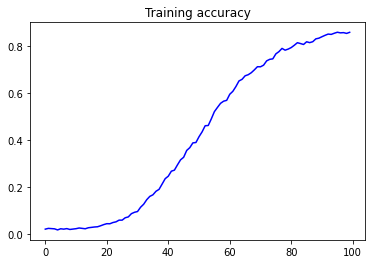

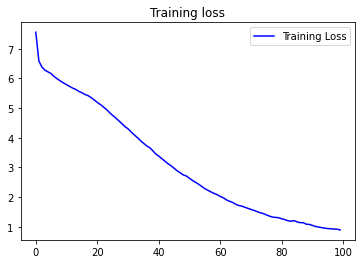

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [17]:
seed_text = "gelas"
next_words = 3
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list).argmax(axis =1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(' '.join(seed_text.split(' ')[::-1]))

dan bukan kurang gelas


# **Import the model**

In [19]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 112kB 24.1MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [21]:
import tensorflowjs as tfjs

def save_model(model):
  model.save('pantun_generator_model.h5')
  tfjs.converters.save_keras_model(model, 'gdrive/MyDrive/tfjs')

save_model(model)

In [22]:
!zip -r file.zip pantun_generator_model.h5

  adding: pantun_generator_model.h5 (deflated 25%)


In [23]:
from google.colab import files
files.download("file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>